# ECM-Based Pair Trading Strategy with Yahoo Finance Data

This notebook:
1. Downloads adjusted close prices for two stocks from Yahoo Finance
2. Tests for cointegration (Johansen)
3. Fits a Vector Error-Correction Model (VECM)
4. Generates one-step-ahead spread forecasts and trading signals
5. Backtests the ECM-based pair trading strategy
6. Plots cumulative P&L

**Note:** Install required packages with `pip install yfinance statsmodels` if needed.

In [14]:
# Parameters
tickers = ['XOM', 'CVX']  # pair of stocks
start_date = '2020-01-01'
end_date   = '2025-08-01'
ecm_lags   = 1            # number of lagged diffs in VECM
window = 252             # rolling window size for backtest
threshold = 0.0          # threshold on forecasted delta spread for signals

In [15]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM

# Ensure plots inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 5)

/var/folders/5z/4d37vf3j0_zcmwxg66l_bmm80000gn/T/ipykernel_20195/664046569.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  2 of 2 completed


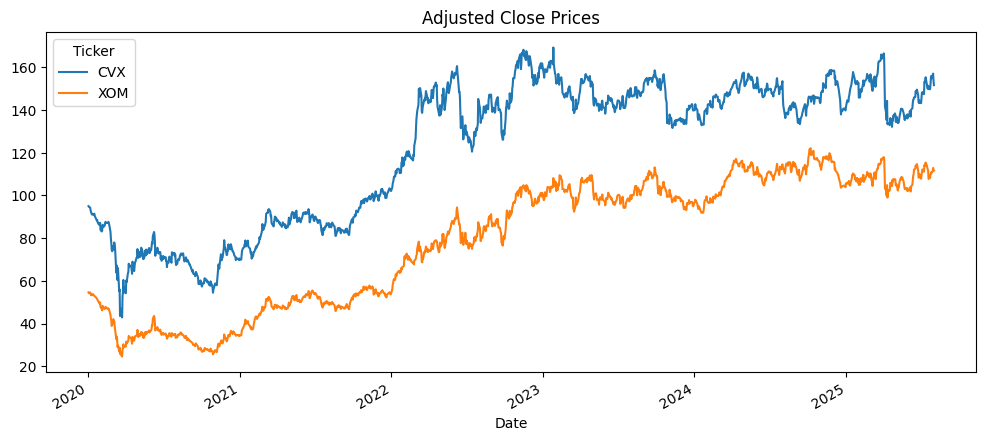

In [16]:
# 1. Download data
prices = yf.download(tickers, start=start_date, end=end_date)['Close']
prices = prices.dropna()
prices.plot(title='Adjusted Close Prices')
plt.show()

## 2. Johansen Cointegration Test
Test for one cointegration relationship between the two price series.

In [17]:
jres = coint_johansen(prices, det_order=0, k_ar_diff=ecm_lags)
print('Trace Statistics:', jres.lr1)
print('Critical Values (90%, 95%, 99%):')
print(jres.cvt)

Trace Statistics: [8.15838206 0.76358413]
Critical Values (90%, 95%, 99%):
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


## 3. Fit VECM
Fit a Vector Error-Correction Model with the cointegration rank = 1.

In [18]:
# Fit VECM
vecm = VECM(prices, k_ar_diff=ecm_lags, coint_rank=1, deterministic='n')
vecm_res = vecm.fit()
print(vecm_res.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation CVX
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.CVX        -0.0483      0.050     -0.970      0.332      -0.146       0.049
L1.XOM         0.0819      0.077      1.058      0.290      -0.070       0.234
Det. terms outside the coint. relation & lagged endog. parameters for equation XOM
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.CVX        -0.0373      0.032     -1.167      0.243      -0.100       0.025
L1.XOM         0.0635      0.050      1.277      0.202      -0.034       0.161
                Loading coefficients (alpha) for equation CVX                 
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

/Users/hadi/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## 4. Forecast ΔSpread & Generate Signals
- Compute the cointegration vector β and error-correction term
- Forecast one-step-ahead Δprices and Δspread
- Generate long/short spread signals based on Δspread forecast

In [20]:
# Cointegration vector (first column)
beta = vecm_res.beta[:, 0]
# Error-correction coefficients (alpha)
alpha = vecm_res.alpha[:, 0]

# Compute spread series
df = prices.copy()
df['spread'] = beta[0]*df[tickers[0]] + beta[1]*df[tickers[1]]

# Forecast next Δprices and Δspread
last_prices = prices.values[-1]
last_diff = prices.diff().values[-1]
ec_term = alpha.dot(prices.values[-1])
sr_term = vecm_res.gamma[0].dot(last_diff)
delta_forecast = ec_term + sr_term
delta_spread_forecast = float((beta * delta_forecast).sum())

print(f'Forecast Δprices: {delta_forecast}')
print(f'Forecast Δspread: {delta_spread_forecast}')

# Generate signal
def signal_from_forecast(dfsf, thresh):
    if dfsf > thresh: return 1
    elif dfsf < -thresh: return -1
    else: return 0

signal = signal_from_forecast(delta_spread_forecast, threshold)
print('Trading signal (1 long, -1 short, 0 flat):', signal)

Forecast Δprices: 0.5914614269554471
Forecast Δspread: -0.22365528277680713
Trading signal (1 long, -1 short, 0 flat): -1


## 5. Backtest ECM-Based Strategy (Rolling Window)
For each day after the initial window:
1. Fit VECM on the past `window` days
2. Forecast Δspread for the next day
3. Take position based on forecast
4. Compute daily P&L and cumulative P&L

/Users/hadi/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/hadi/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/hadi/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/hadi/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

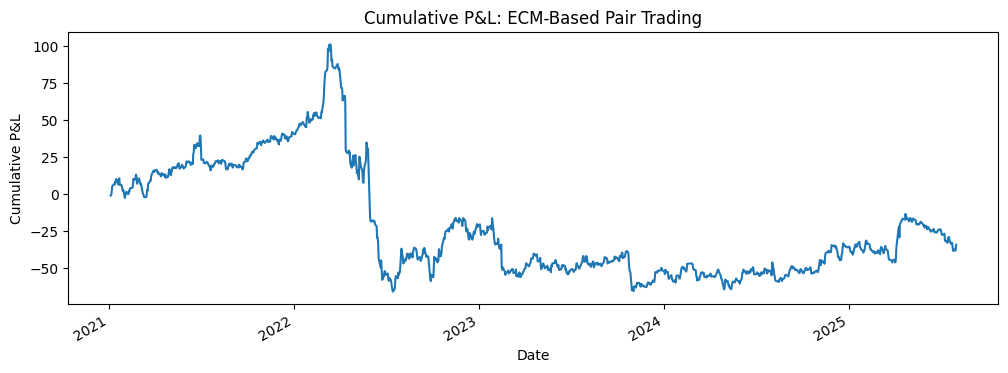

In [22]:
results = []
for start in range(0, len(prices)-window-1):
    train = prices.iloc[start:start+window]
    model = VECM(train, k_ar_diff=ecm_lags, coint_rank=1, deterministic='n').fit()
    beta_r = model.beta[:, 0]
    alpha_r = model.alpha[:, 0]

    # forecast
    p_last = prices.values[start+window-1]
    d_last = prices.diff().values[start+window-1]
    ec = alpha_r.dot(p_last)
    sr = model.gamma[0].dot(d_last)
    dfc = ec + sr

    raw_fc = beta_r.dot(dfc)
    dspread_fc = float((beta_r * dfc).sum())
    pos = signal_from_forecast(dspread_fc, threshold)

    # actual next-day spread change
    spread_series = beta_r[0]*prices[tickers[0]] + beta_r[1]*prices[tickers[1]]
    actual_dspread = spread_series.diff().iloc[start+window]
    pnl = pos * actual_dspread
    results.append(pnl)

pnl_series = pd.Series(results, index=prices.index[window+1:])
cum_pnl = pnl_series.cumsum()

plt.figure(figsize=(12,4))
cum_pnl.plot(title='Cumulative P&L: ECM-Based Pair Trading')
plt.ylabel('Cumulative P&L')
plt.show()

### Summary
- We used a rolling-window VECM to forecast the spread.
- Signals were generated from the forecasted Δspread.
- Backtesting shows the cumulative P&L over the period.